## Installing required dependencies

In [ ]:
!pip install duckdb --no-index --find-links=/kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
!pip install python-gdcm
!pip install pylibjpeg
!pip install pylibjpeg-libjpeg==2.2.0
!pip install pylibjpeg-openjpeg==2.3.0
!pip install matplotlib==3.10.3
!pip install scikit-learn==1.7.0
!pip install polars --no-index --find-links=/kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/polars_pkg
!pip install pydicom

## Importing required libraries

In [3]:
from pydicom import dcmread
from pydicom.dataset import FileDataset, FileMetaDataset
from pydicom.uid import generate_uid, ImplicitVRLittleEndian

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import polars as pl
import duckdb as dd
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import pickle
import gc
import ctypes
from pathlib import Path
import logging
import json
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor
import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras

E0000 00:00:1756017656.845724      11 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


## Initializing the TPU

In [4]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

print("Number of accelerators: ", tpu_strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1756017674.777750      11 service.cc:148] XLA service 0x5b468917fce0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756017674.777795      11 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1756017674.777800      11 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1756017674.777802      11 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1756017674.777805      11 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1756017674.777808      11 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1756017674.777810      11 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1756017674.777813      11 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1756017674.777815      11 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

## Setting polars configs to view the dataframes better

In [5]:
pl.Config(fmt_str_lengths=1000)
pl.Config.set_tbl_rows(1000)

polars.config.Config

# Load the metadata of the training images
## Also separate out the localizer coordinates into individual columns

In [7]:
train_meta_data = pl.read_csv('/kaggle/input/rsna-intracranial-aneurysm-detection/train.csv'\
                              , low_memory=True)

train_locale_meta_data = pl.read_csv('/kaggle/input/rsna-intracranial-aneurysm-detection/train_localizers.csv'\
                              , low_memory=True)

def parse_coordinates(coord_str):
    if coord_str is None:
        return None, None
    try:
        coord_dict = json.loads(coord_str.replace("'", '"'))
        return float(coord_dict.get('x', 0.0)), float(coord_dict.get('y', 0.0)), int(coord_dict.get('f', 0.0))
    except (json.JSONDecodeError, KeyError, ValueError, AttributeError):
        return None, None

train_locale_meta_data = train_locale_meta_data.with_columns([
    pl.col("coordinates")
    .map_elements(lambda x: parse_coordinates(x)[0], return_dtype=pl.Float64)
    .cast(pl.Float64)
    .alias("coordinates_x"),
    
    pl.col("coordinates")
    .map_elements(lambda x: parse_coordinates(x)[1], return_dtype=pl.Float64)
    .cast(pl.Float64)
    .alias("coordinates_y"),
    
    pl.col("coordinates")
    .map_elements(lambda x: parse_coordinates(x)[2], return_dtype=pl.Int32)
    .cast(pl.Int32)
    .alias("coordinates_f")
])

print("Train CSV shape : ", train_meta_data.shape)
print("Train Localizers CSV shape : ", train_locale_meta_data.shape)
# Show the first few rows
print(train_locale_meta_data.filter(pl.col('coordinates_f') != 0.0)\
      .select(["coordinates", "coordinates_x", "coordinates_y", "coordinates_f"]).head(5))

Train CSV shape :  (4348, 18)
Train Localizers CSV shape :  (2251, 7)
shape: (5, 4)
┌────────────────────────────────┬───────────────┬───────────────┬───────────────┐
│ coordinates                    ┆ coordinates_x ┆ coordinates_y ┆ coordinates_f │
│ ---                            ┆ ---           ┆ ---           ┆ ---           │
│ str                            ┆ f64           ┆ f64           ┆ i32           │
╞════════════════════════════════╪═══════════════╪═══════════════╪═══════════════╡
│ {'x': 272.41014419367286, 'y': ┆ 272.410144    ┆ 194.117971    ┆ 58            │
│ 194.11797116126544, 'f': 58}   ┆               ┆               ┆               │
│ {'x': 262.09232271634613, 'y': ┆ 262.092323    ┆ 208.984615    ┆ 8             │
│ 208.98461538461538, 'f': 8}    ┆               ┆               ┆               │
│ {'x': 287.35893155258765, 'y': ┆ 287.358932    ┆ 205.382304    ┆ 74            │
│ 205.38230383973288, 'f': 74}   ┆               ┆               ┆               │
│ {

## Glancing at the datasets so far

In [ ]:
train_meta_data.head(10)

In [ ]:
train_locale_meta_data.head(10)

### Get summary statistics of the new columns

In [ ]:
print(train_locale_meta_data.select(["coordinates_x", "coordinates_y", "coordinates_f"]).describe())

# Get the image metadata from each training series and create a dataframe out of them

In [8]:
allowed_tags = ['BitsAllocated', 'BitsStored', 'Rows', 'Columns', 'FrameOfReferenceUID', 'HighBit', 'ImageOrientationPatient'
                , 'ImagePositionPatient', 'InstanceNumber', 'Modality', 'PhotometricInterpretation'
                , 'PixelRepresentation', 'PixelSpacing', 'PlanarConfiguration', 'RescaleIntercept', 'RescaleSlope'
                , 'RescaleType', 'SamplesPerPixel', 'SliceThickness', 'SpacingBetweenSlices']

## Functions to collect metadata without the image arrays
### We use python slots to reduce the memory foorprint
### Also use multithreading to speed up processing

In [9]:
class DicomRecord:
    """
    Memory-efficient class for storing DICOM metadata using __slots__
    """
    __slots__ = ['folder_name', 'file_name', 'file_path', 'image_shape'] + [
        'BitsAllocated', 'BitsStored', 'Rows', 'Columns', 'FrameOfReferenceUID',
        'HighBit', 'ImageOrientationPatient', 'ImagePositionPatient', 'InstanceNumber',
        'Modality', 'PhotometricInterpretation', 'PixelRepresentation', 'PixelSpacing',
        'PlanarConfiguration', 'RescaleIntercept', 'RescaleSlope', 'RescaleType',
        'SamplesPerPixel', 'SliceThickness', 'SpacingBetweenSlices'
    ]
    
    def __init__(self, folder_name, file_name, file_path, image_shape):
        self.folder_name = folder_name
        self.file_name = file_name
        self.file_path = file_path
        self.image_shape = image_shape
        for tag in self.__slots__[4:]:  
            setattr(self, tag, None)
    
    def to_dict(self):
        return {slot: getattr(self, slot) for slot in self.__slots__}

In [10]:
def process_single_folder(folder_path, allowed_tags):
    """
    Process a single folder of DICOM files and save image arrays
    """
    try:
        data = []
        dcm_files = list(Path(folder_path).glob("*.dcm"))
        folder_name = Path(folder_path).name
        
        for dcm_file in dcm_files:
            try:
                # Read DICOM file
                ds = dcmread(str(dcm_file))
                original_shape = str(ds.pixel_array.shape)
                
                # Create record
                record = DicomRecord(folder_name, dcm_file.name, str(dcm_file), original_shape)
                
                # Fill in tags
                for tag in allowed_tags:
                    try:
                        value = getattr(ds, tag)
                        if hasattr(value, '__iter__') and not isinstance(value, str):
                            value = str(list(map(str, value)))
                        else:
                            value = str(value)
                        setattr(record, tag, value)
                    except (AttributeError, TypeError):
                        continue
                
                data.append(record.to_dict())
                
            except Exception as e:
                print(f"Error processing file {dcm_file}: {e}")
                continue
                
        return data
        
    except Exception as e:
        print(f"Error processing folder {folder_path}: {e}")
        return []

In [11]:
def create_dicom_dataset(root_folder, allowed_tags, num_processes=None, chunk_size=100):
    """
    Create dataset with metadata DataFrame and memory-mapped image arrays
    """
    root_path = Path(root_folder)
    folders = [f for f in root_path.iterdir() if f.is_dir()]
    
    if not num_processes:
        num_processes = mp.cpu_count()
    
    # Create directories for temporary and array storage
    temp_dir = Path("temp_chunks")
    temp_dir.mkdir(exist_ok=True)
    
    # Create schema
    schema = {
        'folder_name': pl.Utf8,
        'file_name': pl.Utf8,
        'file_path': pl.String,
        'image_shape': pl.String
    }
    schema.update({tag: pl.Utf8 for tag in allowed_tags})
    
    # Process folders in parallel
    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        for i in range(0, len(folders), chunk_size):
            chunk_folders = folders[i:i+chunk_size]
            chunk_data = []
            
            futures = [
                executor.submit(
                    process_single_folder, 
                    str(folder), 
                    allowed_tags
                    #arrays_dir
                )
                for folder in chunk_folders
            ]
            
            for future in tqdm(futures, 
                             desc=f"Processing chunk {i//chunk_size + 1}/{(len(folders)-1)//chunk_size + 1}"):
                chunk_data.extend(future.result())
            
            if chunk_data:
                chunk_df = pl.DataFrame(
                    chunk_data,
                    schema=schema,
                    infer_schema_length=None
                )
                
                chunk_df.write_parquet(
                    temp_dir / f"dicom_metadata_chunk_{i//chunk_size}.parquet",
                    compression="snappy"
                )
                
                del chunk_data
                del chunk_df
    
    # Combine chunks
    print("\nCombining chunks...")
    chunk_files = list(temp_dir.glob("dicom_metadata_chunk_*.parquet"))
    final_df = pl.concat([
        pl.scan_parquet(str(chunk_file))
        for chunk_file in chunk_files
    ]).collect()
    
    # Clean up temporary files
    for f in chunk_files:
        f.unlink()
    temp_dir.rmdir()
    
    return final_df

## Starting the collection of metadata

In [12]:
with tpu_strategy.scope():
    root_folder = "/kaggle/input/rsna-intracranial-aneurysm-detection/series"
    
    try:
        metadata_df = create_dicom_dataset(
            root_folder, 
            allowed_tags, 
            num_processes=mp.cpu_count(),
            chunk_size=192
        )
    except Exception as e:
        print(f"Error: {e}")

Processing chunk 23/23: 100%|██████████| 124/124 [00:26<00:00,  4.64it/s]



Combining chunks...


In [13]:
metadata_df.columns

['folder_name',
 'file_name',
 'file_path',
 'image_shape',
 'BitsAllocated',
 'BitsStored',
 'Rows',
 'Columns',
 'FrameOfReferenceUID',
 'HighBit',
 'ImageOrientationPatient',
 'ImagePositionPatient',
 'InstanceNumber',
 'Modality',
 'PhotometricInterpretation',
 'PixelRepresentation',
 'PixelSpacing',
 'PlanarConfiguration',
 'RescaleIntercept',
 'RescaleSlope',
 'RescaleType',
 'SamplesPerPixel',
 'SliceThickness',
 'SpacingBetweenSlices']

# Create the full training data
* Bring in the localizer coordinates for the series where aneurysm is present
* Create another column to signify whether aneurysm is shown in a specific image within a series
* There can be cases where some images of a series cannot catch aneurysm presence
* Bringing all the rows at the image file granularity, i.e. if a file has coordinates then it has aneurysm else not

In [16]:
df_all_coordinates = dd.sql( \
    "select t2.coordinates_x, t2.coordinates_y, t2.coordinates_f, t1.* \
    from metadata_df t1 \
    left join train_locale_meta_data t2 \
    on t1.folder_name = t2.SeriesInstanceUID \
    and replace(t1.file_name, '.dcm','') = t2.SOPInstanceUID "\
).pl()

print(df_all_coordinates.shape)
print(df_all_coordinates.columns)

(1001346, 27)
['coordinates_x', 'coordinates_y', 'coordinates_f', 'folder_name', 'file_name', 'file_path', 'image_shape', 'BitsAllocated', 'BitsStored', 'Rows', 'Columns', 'FrameOfReferenceUID', 'HighBit', 'ImageOrientationPatient', 'ImagePositionPatient', 'InstanceNumber', 'Modality', 'PhotometricInterpretation', 'PixelRepresentation', 'PixelSpacing', 'PlanarConfiguration', 'RescaleIntercept', 'RescaleSlope', 'RescaleType', 'SamplesPerPixel', 'SliceThickness', 'SpacingBetweenSlices']


In [23]:
df_all_data = dd.sql( \
    "select t2.file_name, t2.image_shape, t2.coordinates_x, t2.coordinates_y, t2.coordinates_f \
    , t1.aneurysm_present as aneurysm_present_in_series \
    , case when t2.coordinates_x is not null then 1 else 0 end as aneurysm_present_in_image \
    , t1.seriesinstanceuid, t1.patientage, t1.patientsex, t1.modality \
    , case when t2.coordinates_x is not null then t1.left_infraclinoid_internal_carotid_artery \
    else 0 end as left_infraclinoid_internal_carotid_artery \
    , case when t2.coordinates_x is not null then t1.right_infraclinoid_internal_carotid_artery \
    else 0 end as right_infraclinoid_internal_carotid_artery \
    , case when t2.coordinates_x is not null then t1.left_supraclinoid_internal_carotid_artery \
    else 0 end as left_supraclinoid_internal_carotid_artery \
    , case when t2.coordinates_x is not null then t1.right_supraclinoid_internal_carotid_artery \
    else 0 end as right_supraclinoid_internal_carotid_artery \
    , case when t2.coordinates_x is not null then t1.left_middle_cerebral_artery \
    else 0 end as left_middle_cerebral_artery \
    , case when t2.coordinates_x is not null then t1.right_middle_cerebral_artery \
    else 0 end as right_middle_cerebral_artery \
    , case when t2.coordinates_x is not null then t1.anterior_communicating_artery \
    else 0 end as anterior_communicating_artery \
    , case when t2.coordinates_x is not null then t1.left_anterior_cerebral_artery \
    else 0 end as left_anterior_cerebral_artery \
    , case when t2.coordinates_x is not null then t1.right_anterior_cerebral_artery \
    else 0 end as right_anterior_cerebral_artery \
    , case when t2.coordinates_x is not null then t1.left_posterior_communicating_artery \
    else 0 end as left_posterior_communicating_artery \
    , case when t2.coordinates_x is not null then t1.right_posterior_communicating_artery \
    else 0 end as right_posterior_communicating_artery \
    , case when t2.coordinates_x is not null then t1.basilar_tip \
    else 0 end as basilar_tip \
    , case when t2.coordinates_x is not null then t1.other_posterior_circulation \
    else 0 end as other_posterior_circulation \
    from train_meta_data t1 \
    join df_all_coordinates t2 \
    on t1.SeriesInstanceUID = t2.folder_name" \
).pl()

print("Full training data: ", df_all_data.shape)
print("Full training data columns: ", df_all_data.columns)
print("Aneurysm not present in {0} series".format(df_all_data.filter(pl.col("coordinates_x").is_null()).shape[0]))

print("Aneurysm present in {0} series".format(df_all_data.filter(pl.col("coordinates_x").is_not_null()).shape[0]))

print("Aneurysm not shown in {0} images".format(df_all_data.filter(pl.col("aneurysm_present_in_image")==0).shape[0]))

print("Aneurysm shown in {0} images".format(df_all_data.filter(pl.col("aneurysm_present_in_image")==1).shape[0]))

print(df_all_data.select(["coordinates_x", "coordinates_y"]).describe())

Full training data:  (1001346, 24)
Full training data columns:  ['file_name', 'image_shape', 'coordinates_x', 'coordinates_y', 'coordinates_f', 'aneurysm_present_in_series', 'aneurysm_present_in_image', 'seriesinstanceuid', 'patientage', 'patientsex', 'modality', 'left_infraclinoid_internal_carotid_artery', 'right_infraclinoid_internal_carotid_artery', 'left_supraclinoid_internal_carotid_artery', 'right_supraclinoid_internal_carotid_artery', 'left_middle_cerebral_artery', 'right_middle_cerebral_artery', 'anterior_communicating_artery', 'left_anterior_cerebral_artery', 'right_anterior_cerebral_artery', 'left_posterior_communicating_artery', 'right_posterior_communicating_artery', 'basilar_tip', 'other_posterior_circulation']
Aneurysm not present in 999097 series
Aneurysm present in 2249 series
Aneurysm not shown in 999097 images
Aneurysm shown in 2249 images
shape: (9, 3)
┌────────────┬───────────────┬───────────────┐
│ statistic  ┆ coordinates_x ┆ coordinates_y │
│ ---        ┆ ---    

In [24]:
df_all_data.write_parquet('full_training_data.parquet')

# Looking at a specific CTA image that shows aneurysm
## Taking a multi-frame image by converting it to single-frame image

In [25]:
df_all_data = pl.read_parquet('/kaggle/input/rsna-aneurysm-train-metadata-suman/full_training_data.parquet')
print("Shape of training metadata", df_all_data.shape)
df_all_data.columns

Shape of training metadata (1001346, 24)


['file_name',
 'image_shape',
 'coordinates_x',
 'coordinates_y',
 'coordinates_f',
 'aneurysm_present_in_series',
 'aneurysm_present_in_image',
 'seriesinstanceuid',
 'patientage',
 'patientsex',
 'modality',
 'left_infraclinoid_internal_carotid_artery',
 'right_infraclinoid_internal_carotid_artery',
 'left_supraclinoid_internal_carotid_artery',
 'right_supraclinoid_internal_carotid_artery',
 'left_middle_cerebral_artery',
 'right_middle_cerebral_artery',
 'anterior_communicating_artery',
 'left_anterior_cerebral_artery',
 'right_anterior_cerebral_artery',
 'left_posterior_communicating_artery',
 'right_posterior_communicating_artery',
 'basilar_tip',
 'other_posterior_circulation']

In [26]:
df_all_data.filter(
    (pl.col('coordinates_x').is_not_null())
    &
    (pl.col('coordinates_f') != 0)
).head(10)

file_name,image_shape,coordinates_x,coordinates_y,coordinates_f,aneurysm_present_in_series,aneurysm_present_in_image,seriesinstanceuid,patientage,patientsex,modality,left_infraclinoid_internal_carotid_artery,right_infraclinoid_internal_carotid_artery,left_supraclinoid_internal_carotid_artery,right_supraclinoid_internal_carotid_artery,left_middle_cerebral_artery,right_middle_cerebral_artery,anterior_communicating_artery,left_anterior_cerebral_artery,right_anterior_cerebral_artery,left_posterior_communicating_artery,right_posterior_communicating_artery,basilar_tip,other_posterior_circulation
str,str,f64,f64,i32,i64,i32,str,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""1.2.826.0.1.3680043.8.498.42869495026349479137655237867466396964.dcm""","""(150, 528, 528)""",297.728962,209.570827,65,1,1,"""1.2.826.0.1.3680043.8.498.10656705618563493995266564048457485210""",80,"""Male""","""MRA""",1,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.12112808457186454422752724768665392380.dcm""","""(165, 512, 512)""",256.000511,185.711138,93,1,1,"""1.2.826.0.1.3680043.8.498.10722329050491929401656671952575354429""",54,"""Male""","""MRA""",0,0,0,0,0,0,1,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.97121094041712829608625148100059963709.dcm""","""(150, 512, 512)""",277.935484,190.29453,71,1,1,"""1.2.826.0.1.3680043.8.498.10733938921373716882398209756836684843""",51,"""Female""","""MRA""",0,0,1,0,1,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.97121094041712829608625148100059963709.dcm""","""(150, 512, 512)""",277.935484,190.29453,71,1,1,"""1.2.826.0.1.3680043.8.498.10733938921373716882398209756836684843""",51,"""Female""","""MRA""",0,0,1,0,1,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.75624390816274267057679985409783222714.dcm""","""(150, 512, 512)""",241.785246,212.788225,69,1,1,"""1.2.826.0.1.3680043.8.498.11214867600930976749338633984904421919""",63,"""Male""","""MRA""",0,1,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.61227523131398345421463995264727210232.dcm""","""(25, 528, 528)""",180.017673,195.958763,8,1,1,"""1.2.826.0.1.3680043.8.498.11260672296408433852355455821741549623""",60,"""Female""","""MRI T2""",0,0,0,0,0,1,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.12524552726742591936607820382077304797.dcm""","""(150, 512, 512)""",272.410144,194.117971,58,1,1,"""1.2.826.0.1.3680043.8.498.10134365079002163886508836892471866754""",36,"""Female""","""MRA""",0,0,1,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.35987680962070754560160756829496799559.dcm""","""(24, 528, 528)""",262.092323,208.984615,8,1,1,"""1.2.826.0.1.3680043.8.498.10207110118916220264491289532161991004""",55,"""Female""","""MRI T2""",0,0,0,0,0,0,1,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.41843700716444903986543599702134548656.dcm""","""(29, 512, 512)""",172.400147,252.309305,11,1,1,"""1.2.826.0.1.3680043.8.498.18831402822041226140887003611379903167""",66,"""Female""","""MRI T2""",0,0,0,0,0,1,0,0,0,0,0,0,0


In [28]:
df_all_data.filter(
    (pl.col('coordinates_x').is_not_null())
    &
    (pl.col('coordinates_f') != 0)
).select(pl.col('file_name')).count()

file_name
u32
141


In [40]:
def extract_single_frame(multiframe_path, slice_number, output_path=None):
    """
    Extract a single frame from a multi-frame DICOM
    
    Args:
        multiframe_path: Path to multi-frame DICOM file
        slice_number: The slice number to extract (0-based index)
        output_path: Path to save the single-frame DICOM. If None, returns the dataset
    """
    try:
        # Read the multi-frame DICOM with force=True to handle potentially corrupted files
        multi_ds = dcmread(multiframe_path, force=True)
        
        # Verify it's a multi-frame image
        if not hasattr(multi_ds, 'NumberOfFrames'):
            raise ValueError("Input DICOM is not a multi-frame image")
        
        # Check if slice number is valid
        if slice_number >= multi_ds.NumberOfFrames:
            raise ValueError(f"Slice number {slice_number} is out of range. "
                           f"Image has {multi_ds.NumberOfFrames} frames")
        
        # Create new dataset for single frame
        single_ds = FileDataset(output_path or "temp.dcm", {}, 
                              file_meta=FileMetaDataset(), 
                              preamble=b"\0" * 128)
        
        # Copy attributes from multi-frame dataset
        attrs_to_copy = allowed_tags
        
        for attr in attrs_to_copy:
            if hasattr(multi_ds, attr):
                setattr(single_ds, attr, getattr(multi_ds, attr))
        
        # Generate new UIDs
        single_ds.SOPInstanceUID = generate_uid()
        single_ds.file_meta.MediaStorageSOPInstanceUID = single_ds.SOPInstanceUID
        
        # Set transfer syntax to uncompressed little endian
        single_ds.file_meta.TransferSyntaxUID = ImplicitVRLittleEndian
        single_ds.file_meta.MediaStorageSOPClassUID = multi_ds.file_meta.MediaStorageSOPClassUID
        if hasattr(multi_ds.file_meta, 'ImplementationClassUID'):
            single_ds.file_meta.ImplementationClassUID = multi_ds.file_meta.ImplementationClassUID
        
        # Set instance-specific attributes
        single_ds.InstanceNumber = slice_number + 1
        
        try:
            # Try to get pixel array directly
            pixel_array = multi_ds.pixel_array[slice_number]
        except Exception as e:
            print(f"Warning: Could not directly access pixel_array: {e}")
            # Alternative approach: decompress and get pixels
            if hasattr(multi_ds, 'decompress'):
                multi_ds.decompress()
            pixel_array = multi_ds.pixel_array[slice_number]
        
        # Set pixel data
        single_ds.PixelData = pixel_array.tobytes()
        
        # Update image-specific attributes
        single_ds.NumberOfFrames = 1
        
        # Try to copy position and orientation
        try:
            if hasattr(multi_ds, 'PerFrameFunctionalGroupsSequence'):
                frame_content = multi_ds.PerFrameFunctionalGroupsSequence[slice_number]
                
                if hasattr(frame_content, 'PlanePositionSequence'):
                    position = frame_content.PlanePositionSequence[0].ImagePositionPatient
                    single_ds.ImagePositionPatient = position
                
                if hasattr(frame_content, 'PlaneOrientationSequence'):
                    orientation = frame_content.PlaneOrientationSequence[0].ImageOrientationPatient
                    single_ds.ImageOrientationPatient = orientation
        except Exception as e:
            print(f"Warning: Could not copy position/orientation: {e}")
        
        # Add creation timestamp
        dt = datetime.datetime.now()
        single_ds.ContentDate = dt.strftime('%Y%m%d')
        single_ds.ContentTime = dt.strftime('%H%M%S.%f')
        
        # Save or return the dataset
        if output_path:
            single_ds.save_as(output_path, write_like_original=False)
            return None
        return single_ds
    
    except Exception as e:
        print(f"Error extracting frame: {e}")
        raise

# Alternative version using different approach for compressed files
def extract_single_frame_alternative(multiframe_path, slice_number, output_path=None):
    """
    Alternative version for handling problematic files
    """
    try:
        # Read with force and stop before pixels
        multi_ds = dcmread(multiframe_path, force=True, stop_before_pixels=True)
        
        # Read pixel data separately
        with open(multiframe_path, 'rb') as f:
            multi_ds.PixelData = f.read()
        
        # Decompress if needed
        if hasattr(multi_ds, 'decompress'):
            multi_ds.decompress()
        
        # Get pixel array
        pixel_array = multi_ds.pixel_array[slice_number]
        
        # Create new dataset
        single_ds = FileDataset(output_path or "temp.dcm", {}, 
                              file_meta=FileMetaDataset(), 
                              preamble=b"\0" * 128)
        
        # Copy attributes (same as before)
        attrs_to_copy = allowed_tags
        
        for attr in attrs_to_copy:
            if hasattr(multi_ds, attr):
                setattr(single_ds, attr, getattr(multi_ds, attr))
        
        # Generate new UIDs
        single_ds.SOPInstanceUID = generate_uid()
        single_ds.file_meta.MediaStorageSOPInstanceUID = single_ds.SOPInstanceUID
        
        # Set transfer syntax to uncompressed little endian
        single_ds.file_meta.TransferSyntaxUID = ImplicitVRLittleEndian
        single_ds.file_meta.MediaStorageSOPClassUID = multi_ds.file_meta.MediaStorageSOPClassUID
        if hasattr(multi_ds.file_meta, 'ImplementationClassUID'):
            single_ds.file_meta.ImplementationClassUID = multi_ds.file_meta.ImplementationClassUID
        
        # Set instance-specific attributes
        single_ds.InstanceNumber = slice_number + 1
        
        try:
            # Try to get pixel array directly
            pixel_array = multi_ds.pixel_array[slice_number]
        except Exception as e:
            print(f"Warning: Could not directly access pixel_array: {e}")
            # Alternative approach: decompress and get pixels
            if hasattr(multi_ds, 'decompress'):
                multi_ds.decompress()
            pixel_array = multi_ds.pixel_array[slice_number]
        
        # Set pixel data
        single_ds.PixelData = pixel_array.tobytes()
        
        # Update image-specific attributes
        single_ds.NumberOfFrames = 1
        
        # Try to copy position and orientation
        try:
            if hasattr(multi_ds, 'PerFrameFunctionalGroupsSequence'):
                frame_content = multi_ds.PerFrameFunctionalGroupsSequence[slice_number]
                
                if hasattr(frame_content, 'PlanePositionSequence'):
                    position = frame_content.PlanePositionSequence[0].ImagePositionPatient
                    single_ds.ImagePositionPatient = position
                
                if hasattr(frame_content, 'PlaneOrientationSequence'):
                    orientation = frame_content.PlaneOrientationSequence[0].ImageOrientationPatient
                    single_ds.ImageOrientationPatient = orientation
        except Exception as e:
            print(f"Warning: Could not copy position/orientation: {e}")
        
        # Add creation timestamp
        dt = datetime.datetime.now()
        single_ds.ContentDate = dt.strftime('%Y%m%d')
        single_ds.ContentTime = dt.strftime('%H%M%S.%f')
        
        # Save or return the dataset
        if output_path:
            single_ds.save_as(output_path, write_like_original=False)
            return None
        return single_ds
        
    except Exception as e:
        print(f"Error in alternative extraction: {e}")
        raise

# Function to try both methods
def safe_extract_single_frame(multiframe_path, slice_number, output_path=None):
    """
    Try both extraction methods
    """
    try:
        return extract_single_frame(multiframe_path, slice_number, output_path)
    except Exception as e:
        print(f"Primary method failed: {e}")
        print("Trying alternative method...")
        try:
            return extract_single_frame_alternative(multiframe_path, slice_number, output_path)
        except Exception as e2:
            print(f"Alternative method also failed: {e2}")
            raise

# Version with zoom functionality
def load_and_view_single_slice_with_zoom(dcm_path, x_coord, y_coord, f_coord=None, zoom_size=100):
    """
    Load and display a single DICOM slice with crosshair and zoomed inset
    
    Args:
        dcm_path: Path to the DICOM file
        x_coord: x coordinate for the crosshair
        y_coord: y coordinate for the crosshair
        zoom_size: Size of the zoom window in pixels
    """
    # Read DICOM file
    if f_coord:
        ds = safe_extract_single_frame(dcm_path, f_coord)
    else:
        ds = dcmread(dcm_path)
    img = ds.pixel_array
    
    # Create figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Main image with crosshair
    ax1.imshow(img, cmap='gray')
    ax1.axvline(x=x_coord, color='red', alpha=0.5)
    ax1.axhline(y=y_coord, color='red', alpha=0.5)
    ax1.plot(x_coord, y_coord, 'r+', markersize=10, markeredgewidth=2)
    
    # Zoomed region
    x_start = int(max(0, x_coord - zoom_size/2))
    x_end = int(min(img.shape[1], x_coord + zoom_size/2))
    y_start = int(max(0, y_coord - zoom_size/2))
    y_end = int(min(img.shape[0], y_coord + zoom_size/2))
    
    zoomed = img[y_start:y_end, x_start:x_end]
    ax2.imshow(zoomed, cmap='gray')
    
    # Add crosshair to zoomed region
    center_x = x_coord - x_start
    center_y = y_coord - y_start
    ax2.axvline(x=center_x, color='red', alpha=0.5)
    ax2.axhline(y=center_y, color='red', alpha=0.5)
    ax2.plot(center_x, center_y, 'r+', markersize=10, markeredgewidth=2)
    
    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title('Full Image')
    ax2.set_title('Zoomed Region')
    
    plt.tight_layout()
    plt.show()

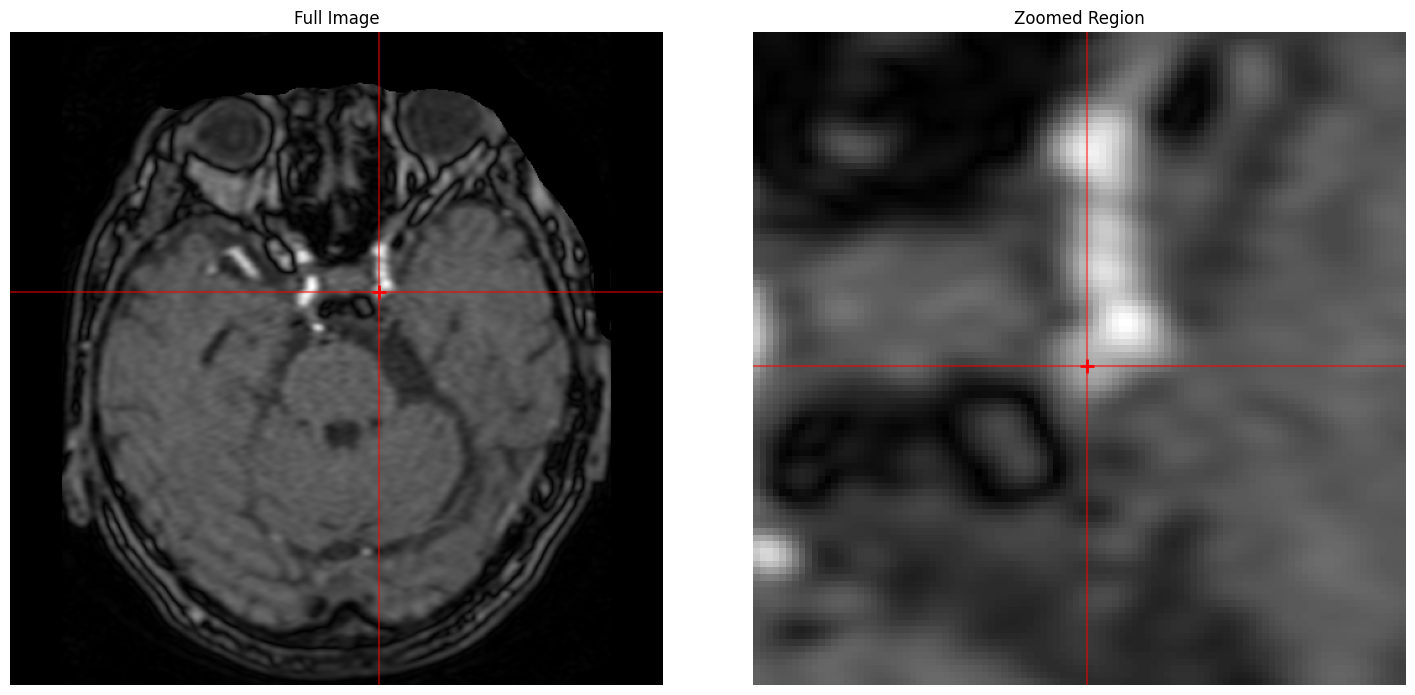

In [41]:
dcm_path = '/kaggle/input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10656705618563493995266564048457485210/1.2.826.0.1.3680043.8.498.42869495026349479137655237867466396964.dcm'
x_coord = 297.728962
y_coord = 209.570827
f_coord = 65
load_and_view_single_slice_with_zoom(dcm_path, x_coord, y_coord, f_coord)